## Imports and constants

ideas: k-fold, transformers, features generation, polars

m.classification_report for sex or eliminate it in age prediction and only leave f1 score

In [1]:
SPLIT_SEED = 42
FAISS_ITERATIONS = 5
KFOLD_SPLITS = 3
IS_EMBEDDING_USED = True
IS_MODEL_CATBOOST = True
IS_NOTEBOOK_ON_KAGGLE = True

if (IS_NOTEBOOK_ON_KAGGLE):
    LOCAL_DATA_PATH = '/kaggle/input/mts-ml-cookies'
    DATA_FILE = 'dataset_full.feather'
    TARGET_FILE = 'target_train.feather'
    SUBMISSION_FILE = 'submission.feather'

In [2]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [3]:
!pip install feather-format >> none -q
!pip install faiss-cpu --no-cache -q
!pip install polars -q

import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pyarrow as pa
import polars as pl

%matplotlib inline
sns.set_style('darkgrid')

## Showing data

In [4]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [5]:
display(id_to_submit.head(3))
id_to_submit.info

,user_id
0,221301
1,31271
2,211594


<bound method DataFrame.info of         user_id
0        221301
1         31271
2        211594
3        253119
4        192578
...         ...
144719   415284
144720   415285
144721   415286
144722   415306
144723   415315

[144724 rows x 1 columns]>

In [6]:
data = pd.read_feather(f'{LOCAL_DATA_PATH}/{DATA_FILE}')

In [7]:
display(data.head())
data.describe()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


,price,request_cnt,user_id
count,3.163100e+08,3.228994e+08,3.228994e+08
mean,3.308510e+04,1.724197e+00,2.070983e+05
std,2.583592e+04,1.213835e+00,1.200584e+05
min,9.000000e+01,1.000000e+00,0.000000e+00
25%,1.397400e+04,1.000000e+00,1.027880e+05
50%,2.199000e+04,1.000000e+00,2.068870e+05
75%,4.999000e+04,2.000000e+00,3.113950e+05
max,1.956570e+05,1.600000e+01,4.153160e+05


In [8]:
data = pa.Table.from_pandas(data)
pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

,field,type
0,region_name,"dictionary<values=string, indices=int8, ordere..."
1,city_name,"dictionary<values=string, indices=int16, order..."
2,cpe_manufacturer_name,"dictionary<values=string, indices=int8, ordere..."
3,cpe_model_name,"dictionary<values=string, indices=int16, order..."
4,url_host,"dictionary<values=string, indices=int32, order..."
5,cpe_type_cd,"dictionary<values=string, indices=int8, ordere..."
6,cpe_model_os_type,"dictionary<values=string, indices=int8, ordere..."
7,price,float
8,date,timestamp[ns]
9,part_of_day,"dictionary<values=string, indices=int8, ordere..."


In [9]:
data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

smartphone    322781599
tablet            53768
plain             36116
phablet           27952
Name: cpe_type_cd, dtype: int64

In [10]:
targets = pd.read_feather(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
targets.head()

,age,is_male,user_id
0,31.0,1,350459
1,35.0,1,188276
2,41.0,0,99002
3,33.0,0,155506
4,54.0,0,213873


In [11]:
targets = pa.Table.from_pandas(targets)
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64


## Counting users <-> items embedding

In [12]:
%%time
if (IS_EMBEDDING_USED):
    data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

    url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
    print(f'{len(url_set)} urls')
    url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
    usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
    print(f'{len(usr_set)} users')
    usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users
CPU times: user 34.3 s, sys: 5.75 s, total: 40 s
Wall time: 39.8 s


In [13]:
%%time
if (IS_EMBEDDING_USED):
    values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
    rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
    cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
    mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
    als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 50, iterations = FAISS_ITERATIONS, use_gpu = False, \
           calculate_training_loss = True, regularization = 0.1)

CPU times: user 2.08 s, sys: 822 ms, total: 2.91 s
Wall time: 2.84 s


In [14]:
%%time
if (IS_EMBEDDING_USED):
    als.fit(mat)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4min 41s, sys: 2.41 s, total: 4min 43s
Wall time: 1min 18s


In [15]:
if (IS_EMBEDDING_USED):
    u_factors = als.user_factors 
    print(len(u_factors))

199683


In [16]:
if (IS_EMBEDDING_USED):
    d_factors = als.item_factors
    print(len(d_factors))

415317


## Sex prediction

In [17]:
id_to_submit = pd.read_feather(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}')

In [18]:
if (IS_EMBEDDING_USED):
    inv_usr_map = {v: k for k, v in usr_dict.items()}
    usr_emb = pd.DataFrame(d_factors)
    usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
    usr_targets = targets.to_pandas()
    df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
    df = df[df['is_male'] != 'NA']
    df = df.dropna()
    df['is_male'] = df['is_male'].map(int)
    print(df['is_male'].value_counts())

1    135314
0    128982
Name: is_male, dtype: int64


#### Model trainings

In [19]:
max_gini = 0
train_index = 0
test_index = 0

In [20]:
%%time
if (IS_MODEL_CATBOOST):
    clf = CatBoostClassifier()

    x = np.array(df.drop(['user_id', 'age', 'is_male'], axis = 1))
    y = np.array(df['is_male'])

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes:", train_index[:5],
              "Test length:", test_index[:5], '\n',
              "Train length:", len(train_index), 
              "Test length:", len(test_index), 
              "Dataset length:", len(x))
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train, verbose = False)
        gini = float(f'{2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')
        if gini > max_gini:
            max_gini = gini
            max_train_index = train_index
            max_test_index = test_index
        
        print(f'GINI по полу {gini}, current max is {max_gini}')
        print()

Train indexes: [88099 88100 88101 88102 88103] Test length: [0 1 2 3 4] 
 Train length: 176197 Test length: 88099 Dataset length: 264296
GINI по полу 0.654, current max is 0.654

Train indexes: [0 1 2 3 4] Test length: [88099 88100 88101 88102 88103] 
 Train length: 176197 Test length: 88099 Dataset length: 264296
GINI по полу 0.65, current max is 0.654

Train indexes: [0 1 2 3 4] Test length: [176198 176199 176200 176201 176202] 
 Train length: 176198 Test length: 88098 Dataset length: 264296
GINI по полу 0.65, current max is 0.654

CPU times: user 9min 57s, sys: 20.1 s, total: 10min 17s
Wall time: 2min 42s


In [21]:
#may try other models later
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
print(clf.predict([[0, 0, 0, 0]]))
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.datasets import make_classification\nX, y = make_classification(n_samples=1000, n_features=4,\n                            n_informative=2, n_redundant=0,\n                           random_state=0, shuffle=False)\nclf = RandomForestClassifier(max_depth=2, random_state=0)\nclf.fit(X, y)\nprint(clf.predict([[0, 0, 0, 0]]))\n'

In [22]:
print(max_gini)
print(max_train_index)
print(max_test_index)

0.654
[ 88099  88100  88101 ... 264293 264294 264295]
[    0     1     2 ... 88096 88097 88098]


In [23]:
if (IS_MODEL_CATBOOST):
    clf.fit(x[max_train_index], y[max_train_index], verbose = False)
    id_to_submit['user_id'].unique

In [24]:
sex_prediction = clf.predict_proba(
    id_to_submit.merge(usr_emb, how = 'left', on = ['user_id'])
)[:,1]

print(len(sex_prediction))
id_to_submit['is_male'] = sex_prediction

144724


In [25]:
print("Current GINI score: ", float(f'{2 * m.roc_auc_score(y[max_test_index], clf.predict_proba(x[max_test_index])[:,1]) - 1:2.3f}'))

Current GINI score:  0.654


## Age prediction

In [26]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

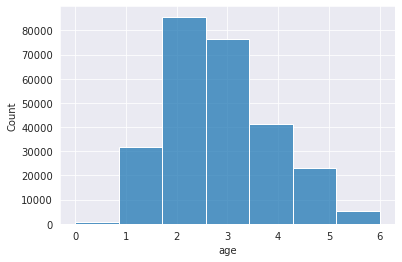

In [27]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [28]:
max_f1 = 0
train_index = 0
test_index = 0

In [29]:
if (IS_MODEL_CATBOOST):
    clf = CatBoostClassifier()

    x = np.array(df.drop(['user_id', 'age', 'is_male'], axis = 1))
    y = np.array(df['age'])

    kf = KFold(n_splits=KFOLD_SPLITS)

    for train_index, test_index in kf.split(x):
        print("Train indexes:", train_index[:5],
              "Test length:", test_index[:5], '\n',
              "Train length:", len(train_index), 
              "Test length:", len(test_index), 
              "Dataset length:", len(x))
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train, verbose = False)
        f1 = m.f1_score(y_test, clf.predict(x_test), average='weighted')
    
        if f1 > max_f1:
            max_f1 = f1
            max_train_index = train_index
            max_test_index = test_index
        
        print(m.classification_report(
            y_test, 
            clf.predict(x_test), 
            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']
        ), '\n')

Train indexes: [88099 88100 88101 88102 88103] Test length: [0 1 2 3 4] 
 Train length: 176197 Test length: 88099 Dataset length: 264296
              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       262
       18-25       0.48      0.26      0.34     10590
       25-34       0.46      0.62      0.53     28502
       35-44       0.38      0.51      0.44     25545
       45-54       0.36      0.17      0.23     13708
       55-65       0.40      0.17      0.24      7695
         65+       0.40      0.01      0.02      1797

    accuracy                           0.42     88099
   macro avg       0.36      0.25      0.26     88099
weighted avg       0.42      0.42      0.40     88099
 

Train indexes: [0 1 2 3 4] Test length: [88099 88100 88101 88102 88103] 
 Train length: 176197 Test length: 88099 Dataset length: 264296
              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       262
       18-25      

In [30]:
print(max_f1)
print(max_train_index[:5])
print(max_test_index[:5])

0.3956013442082641
[88099 88100 88101 88102 88103]
[0 1 2 3 4]


In [31]:
if (IS_MODEL_CATBOOST):
    clf.fit(x[max_train_index], y[max_train_index], verbose = False)
    id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'left', on = ['user_id']))

In [32]:
#id_to_submit['age'] = [0 for n in range(144724)]
#so f1 is around 0.5 while gini is nothing

In [33]:
if (IS_MODEL_CATBOOST):
    print(m.classification_report(
          y[max_test_index], 
          clf.predict(x[max_test_index]), 
          target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']
    ))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       262
       18-25       0.48      0.26      0.34     10590
       25-34       0.46      0.62      0.53     28502
       35-44       0.38      0.51      0.44     25545
       45-54       0.36      0.17      0.23     13708
       55-65       0.40      0.17      0.24      7695
         65+       0.40      0.01      0.02      1797

    accuracy                           0.42     88099
   macro avg       0.36      0.25      0.26     88099
weighted avg       0.42      0.42      0.40     88099



## Submission

In [34]:
display(id_to_submit.head())
print(id_to_submit.is_male.value_counts())
print(id_to_submit.age.value_counts())
id_to_submit.to_csv('submission.csv', index = False)

,user_id,is_male,age
0,221301,0.491065,3
1,31271,0.668735,3
2,211594,0.616308,3
3,253119,0.612069,3
4,192578,0.801855,3


0.524187    227
0.551096    169
0.522411    121
0.543597     93
0.529032     89
           ... 
0.732838      1
0.975465      1
0.545221      1
0.502991      1
0.589028      1
Name: is_male, Length: 141745, dtype: int64
3    98895
2    38704
4     4940
1     1345
5      840
Name: age, dtype: int64


In [35]:
print(f'Score: {max_gini + 2*max_f1}')

Score: 1.4452026884165283
